#Setup

In [ ]:
import os
import sys
import time
import csv
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models  
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import ImageDraw 
from tqdm import tqdm
import torch.optim as optim  
import torch.nn.functional as F

import torchvision.transforms as transforms
from sklearn.preprocessing import normalize
import scipy

# #Make sure to mount drive and that you have access to IDL_group_project. All paths are from the shared folder
# from google.colab import drive
# drive.mount('/content/drive')

#Helper Functions

Below are functions for parsing through file structures

In [ ]:
#This function will return both the path and the file names of all files in a directory
def path_file_list_creator(path, both_path_file = False):
  path_file_list = []
  for myfile in os.listdir(path):
    full_path = os.path.join(path,myfile)
    if both_path_file == True:
      path_file_list.append((full_path, myfile))
    else:
      path_file_list.append(full_path)
  return(path_file_list,len(path_file_list))

#Concate all different classes semantic information together from seperate directories
def concate_directories(paths):
  semantic_bundles_paths_extended = []
  total_files = 0 

  for path in paths:
    class_bundle_paths , num_files = path_file_list_creator(path)
    semantic_bundles_paths_extended.extend(class_bundle_paths)
    total_files += num_files
  print("Total Files grabbed ", total_files)
  return(semantic_bundles_paths_extended)

Below are functions for visualizing and masking images

In [ ]:
#This displays and masks an image. Can be used to verify correct semantic objects are extracted
def display_mask_image(binary_mask, image_path, label, semantic_type=None):
  binary_mask = np.stack([binary_mask, binary_mask, binary_mask], axis=2)
  image = Image.open(image_path)
  image = np.asarray(image)
  masked_image = binary_mask * image
  masked_image = Image.fromarray(masked_image)
  
  #Annotations
  print("Image File: ", image_path)
  print("Class: ", label)
  print("Semantic_type: ", semantic_type)
  display(masked_image)

Below is the custom DataLoader

In [ ]:
class SemanticObjectsLoader(DataLoader):
  def __init__(self, paths, image_folder_path, target_lables):
    self.paths = concate_directories(paths)
    self.image_folder_dir = image_folder_path
    self.target_labels = target_labels
  def __iter__(self):

    for i, path in enumerate(self.paths):
      with open(path, 'rb') as f:
        data = pickle.load(f)
      image_name = data['image_name']
      #We must append the full path name to image_name
      image_name = self.image_folder_dir + image_name + '.jpg'
      num_objects = data["num_objects"]
      #we must iterate through every different object (for example there could be two airplanes in one photo)
      for object_index in range(num_objects):
        #Crawling through each object index
        label = data['objects_list'][object_index]['obj_class']
        if label in self.target_labels:
         
          #We must iterate through every semantic item now
          for semantic_index in range(len(data['objects_list'][object_index]['parts_list'])):
            semantic_mask = data['objects_list'][object_index]['parts_list'][semantic_index]['part_mask']
            semantic_type = data['objects_list'][object_index]['parts_list'][semantic_index]['part_name']
            #Fill in a new entry into the dictionary
            meta_dict = {"image_name": image_name, "label" : label, "semantic_mask" : semantic_mask, "semantic_type" :semantic_type}
            yield meta_dict

    yield full_semantic_list_getter(self.paths)

class SemanticObjectsLoaderPath(DataLoader):
  def __init__(self, paths, image_folder_path):
    self.paths = concate_directories(paths)
    self.image_folder_dir = image_folder_path

  def __iter__(self):
    meta_dict_list = []
    for i, path in enumerate(self.paths):
      yield path

def invert_mask(mask_list):
  inverted_masks = []
  for mask in mask_list:
    #Getting indexes of 0 and 1 values 
    zero_value_idx = mask == 0
    one_value_idx = mask == 1

    #Invert 0 and 1 values
    mask[zero_value_idx] = 1
    mask[one_value_idx] = 0
    inverted_masks.append(mask)

  return(inverted_masks)

class VehicleMasksLoadersNegative(DataLoader):
  def __init__(self, paths, image_folder_path, target_lables, extend=0):
    self.paths = concate_directories(paths)
    self.image_folder_dir = image_folder_path
    self.target_labels = target_labels
    self.extend = extend

  def __iter__(self):
    
    #pdb.set_trace()
    for i, path in enumerate(self.paths):
      with open(path, 'rb') as f:
        data = pickle.load(f)
      image_name = data['image_name']
      #We must append the full path name to image_name
      image_name = self.image_folder_dir + image_name + '.jpg'
      num_objects = data["num_objects"]
      #We must store our object masks to later concatonate 
      obj_masks = []
      #we must iterate through every different object (for example there could be two airplanes in one photo)
      for object_index in range(num_objects):
        #Crawling through each object index
        label = data['objects_list'][object_index]['obj_class']
        #If we are not dealing with a vehicle, then break out 
        if label in self.target_labels:
          obj_masks.append(data['objects_list'][object_index]['obj_mask'])
      
      inverted_masks = invert_mask(obj_masks)
      all_vehicles_masked = combine_masks(inverted_masks, 'negative')
      if self.extend != 0:
        all_vehicles_masked = -all_vehicles_masked + 1
        all_vehicles_masked = scipy.ndimage.morphology.binary_dilation(all_vehicles_masked, iterations=self.extend).astype(all_vehicles_masked[0].dtype) # Extend the mask
        all_vehicles_masked = -all_vehicles_masked + 1

      #Fill in a new entry into the dictionary
      meta_dict = {"image_name": image_name, "label" : label, "obj_mask" : all_vehicles_masked, "object_count" : num_objects}
      yield meta_dict

    # yield full_semantic_list_getter(self.paths)

class VehicleMasksLoadersPositive(DataLoader):
  def __init__(self, paths, image_folder_path, target_lables, extend=0):
    self.paths = concate_directories(paths)
    self.image_folder_dir = image_folder_path
    self.target_labels = target_labels
    self.extend = extend

  def __iter__(self):
    
    #pdb.set_trace()
    for i, path in enumerate(self.paths):
      with open(path, 'rb') as f:
        data = pickle.load(f)
      image_name = data['image_name']
      #We must append the full path name to image_name
      image_name = self.image_folder_dir + image_name + '.jpg'
      num_objects = data["num_objects"]
      #We must store our object masks to later concatonate 
      obj_masks = []
      #we must iterate through every different object (for example there could be two airplanes in one photo)
      for object_index in range(num_objects):
        #Crawling through each object index
        label = data['objects_list'][object_index]['obj_class']
        #If we are not dealing with a vehicle, then break out 
        if label in self.target_labels:
          obj_masks.append(data['objects_list'][object_index]['obj_mask'])
      
      # inverted_masks = invert_mask(obj_masks)
      all_vehicles_masked = combine_masks(obj_masks, 'positive')
      # if self.extend != 0:
      #   all_vehicles_masked = -all_vehicles_masked + 1
      #   all_vehicles_masked = scipy.ndimage.morphology.binary_dilation(all_vehicles_masked, iterations=self.extend).astype(all_vehicles_masked[0].dtype) # Extend the mask
      #   all_vehicles_masked = -all_vehicles_masked + 1

      #Fill in a new entry into the dictionary
      meta_dict = {"image_name": image_name, "label" : label, "obj_mask" : all_vehicles_masked, "object_count" : num_objects}
      yield meta_dict

Returns a list of feature vectors with dimension 512 that contain nonzero values

In [ ]:
'''def combine_masks(mask_list):
  if len(mask_list) == 1:
    return(mask_list[0])
  else:
    full_mask = mask_list[0]

    for mask in mask_list[1:]:
      full_mask *= mask
    return(full_mask)
'''

def combine_masks(mask_list, mode):
  if len(mask_list) == 1:
    return(mask_list[0])
  else:
    full_mask = mask_list[0]

    if mode =='negative':
      for mask in mask_list[1:]:
        full_mask *= mask
    if mode =='positive':
      for mask in mask_list[1:]:
        full_mask += mask
    return(np.clip(full_mask,a_min=0,a_max=1))

# Does not work
# def get_nonzero_feature_vectors(max_pool_layer_4_representation):
#   max_pool_layer_4_representation = max_pool_layer_4_representation.detach().cpu()
#   batch_indices, channel_indices, width_idices, height_indices = torch.nonzero(max_pool_layer_4_representation, as_tuple=True)
#   feature_vector_list = []
#   for non_zero_index in range(len(batch_indices)):
#     feature_vector = max_pool_layer_4_representation[0, : ,width_idices[non_zero_index], height_indices[non_zero_index]].numpy()
#     feature_vector_list.append(feature_vector)
#   return(feature_vector_list)

def get_nonzero_feature_vectors(max_pool_layer_4_representation):
  max_pool_layer_4_representation = max_pool_layer_4_representation.detach().cpu()
  feature_vector_list = []

  batch_size = max_pool_layer_4_representation.shape[0]
  num_channels = max_pool_layer_4_representation.shape[1]
  height = max_pool_layer_4_representation.shape[2]
  width  = max_pool_layer_4_representation.shape[3]
  for b in range(batch_size):
    for h in range(height):
      for w in range(width):
        feature_vector = max_pool_layer_4_representation[b, :, h, w]
        norm_squared = torch.dot(feature_vector, feature_vector)
        if norm_squared > 1e-3:
          feature_vector_list.append(max_pool_layer_4_representation[b, :, h, w].numpy())
  feature_vector_np = np.array(feature_vector_list)
  return feature_vector_np

#Visualizing Masks

In [ ]:
target_labels = ['aeroplane', 'bicycle', 'bus', 'car', 'motorbike', 'train']

# # Google Colab
# image_folder_dir = '/content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/'

# aeroplane_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/aeroplane'
# bicycle_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/bicycle'
# bus_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/bus'
# car_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/car'
# motorbike_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/motorbike'
# train_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/train'

# aeroplane_semantic_part_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/aeroplane'
# bicycle_semantic_part_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/bicycle'
# bus_semantic_part_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/bus'
# car_semantic_part_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/car'
# motorbike_semantic_part_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/motorbike'
# train_semantic_part_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/train'

# Local
image_folder_dir = '/home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/'

aeroplane_annotations_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/aeroplane'
bicycle_annotations_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/bicycle'
bus_annotations_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/bus'
car_annotations_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/car'
motorbike_annotations_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/motorbike'
train_annotations_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/train'

# aeroplane_semantic_part_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/aeroplane'
# bicycle_semantic_part_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/bicycle'
# bus_semantic_part_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/bus'
# car_semantic_part_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/car'
# motorbike_semantic_part_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/motorbike'
# train_semantic_part_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/PASCAL-Part-semantic-pkl/train'

In [ ]:
# Positive masks
# # Old dataloader - 3351 - slow
# all_classes_semantic_paths = [aeroplane_annotations_path,bicycle_annotations_path,bus_annotations_path,car_annotations_path,motorbike_annotations_path,train_annotations_path]
# semantic_dataloader = SemanticObjectsLoader(all_classes_semantic_paths, image_folder_dir, target_labels)
# # Load by paths - 27000
# all_classes_semantic_paths = [aeroplane_semantic_part_path,bicycle_semantic_part_path,bus_semantic_part_path,car_semantic_part_path,motorbike_semantic_part_path,train_semantic_part_path]
# semantic_dataloader = SemanticObjectsLoaderPath(all_classes_semantic_paths, image_folder_dir)
# 3351
# all_classes_annotations_paths = [aeroplane_annotations_path,bicycle_annotations_path,bus_annotations_path,car_annotations_path,motorbike_annotations_path,train_annotations_path]
all_classes_annotations_paths = [car_annotations_path]
positive_dataloader = VehicleMasksLoadersPositive(all_classes_annotations_paths, image_folder_dir, target_labels)

# Negative masks
# all_classes_annotations_paths = [aeroplane_annotations_path,bicycle_annotations_path,bus_annotations_path,car_annotations_path,motorbike_annotations_path,train_annotations_path]
all_classes_annotations_paths = [car_annotations_path]
negative_dataloader = VehicleMasksLoadersNegative(all_classes_annotations_paths, image_folder_dir, target_labels, extend=56)

Total Files grabbed  1034
Total Files grabbed  1034


Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2008_007793.jpg
Class:  car
Semantic_type:  None


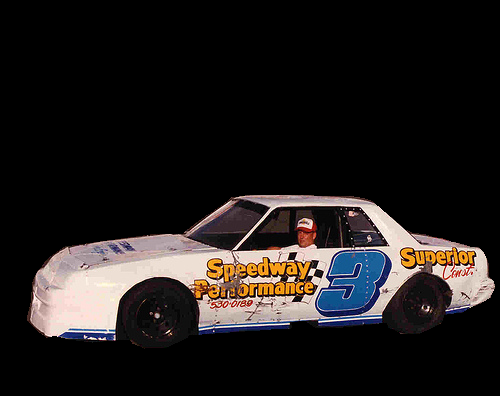

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2010_004661.jpg
Class:  car
Semantic_type:  None


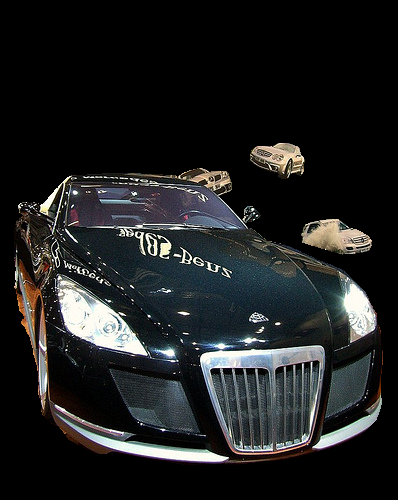

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2010_004021.jpg
Class:  car
Semantic_type:  None


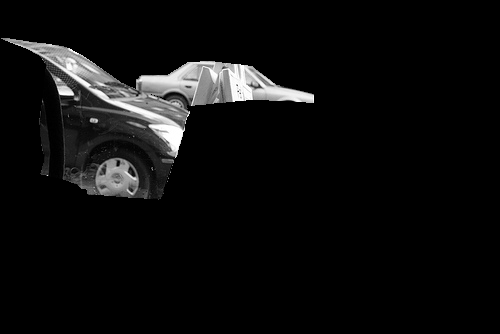

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2008_002943.jpg
Class:  car
Semantic_type:  None


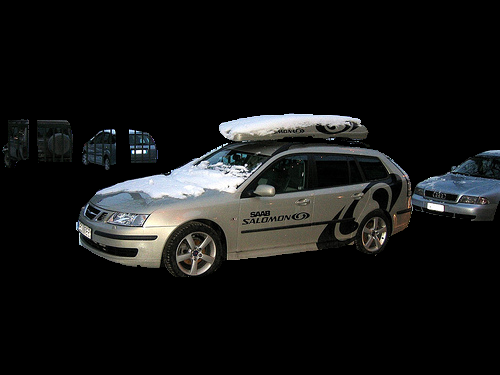

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2008_006365.jpg
Class:  car
Semantic_type:  None


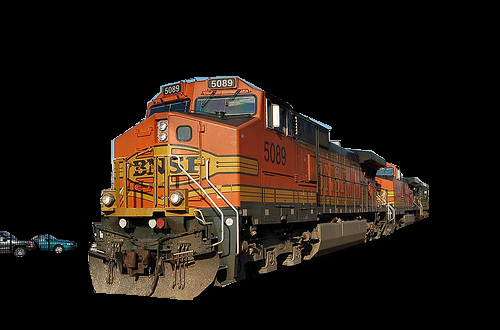

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2010_002363.jpg
Class:  car
Semantic_type:  None


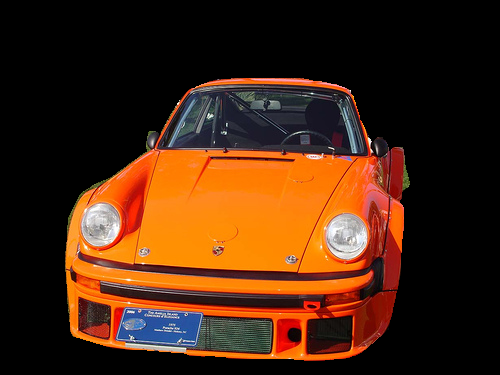

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2009_003589.jpg
Class:  car
Semantic_type:  None


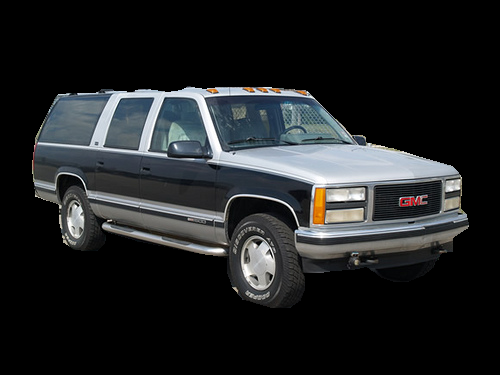

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2008_007793.jpg
Class:  car
Semantic_type:  None


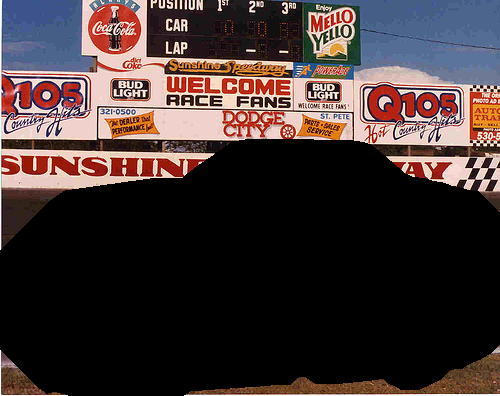

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2010_004661.jpg
Class:  car
Semantic_type:  None


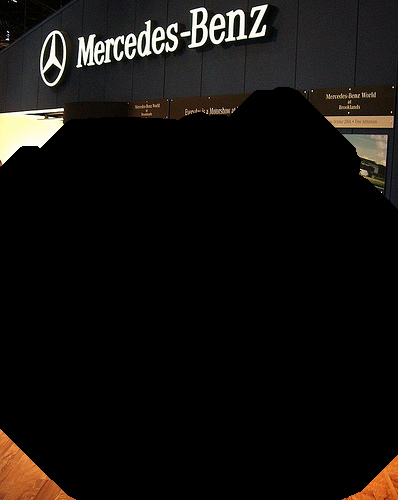

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2010_004021.jpg
Class:  car
Semantic_type:  None


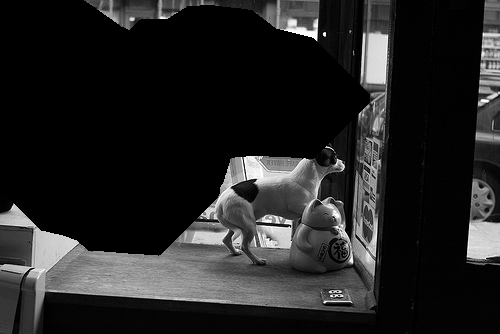

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2008_002943.jpg
Class:  car
Semantic_type:  None


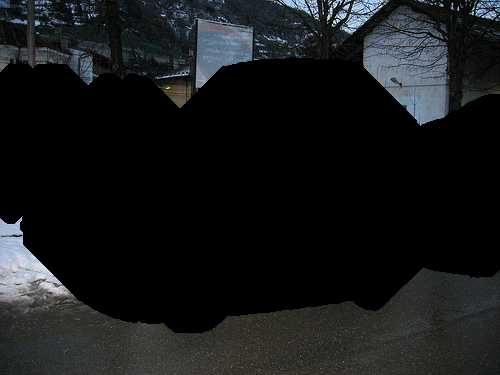

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2008_006365.jpg
Class:  car
Semantic_type:  None


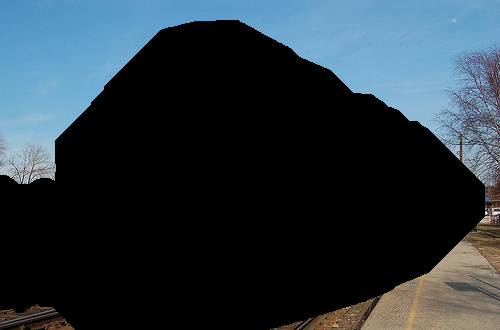

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2010_002363.jpg
Class:  car
Semantic_type:  None


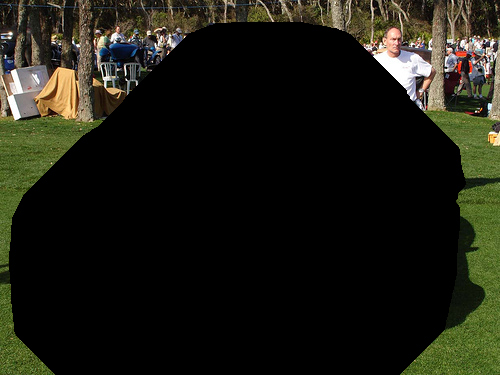

Image File:  /home/tunx404/SSD1/Miscellaneous/IDL/data/PASCAL VOC2010/VOCtrainval_03-May-2010/VOCdevkit/VOC2010/JPEGImages/2009_003589.jpg
Class:  car
Semantic_type:  None


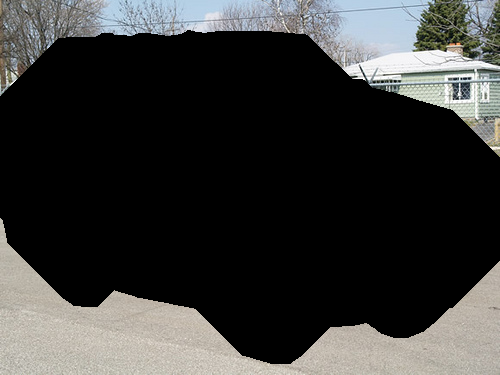

In [ ]:
# Postive
for i, meta_dict in enumerate(positive_dataloader):
  display_mask_image(meta_dict['obj_mask'], meta_dict['image_name'], meta_dict['label'])
  if i > 5: break

# Negative
for i, meta_dict in enumerate(negative_dataloader):
  display_mask_image(meta_dict['obj_mask'], meta_dict['image_name'], meta_dict['label'])
  if i > 5: break

#Running Data through VGG16

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = models.vgg16(pretrained=True).features[:24].to(device)
model.eval()

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# Create fp sets

In [ ]:
from numpy import linalg as LA

# Google Colab
# fp_positive_dir = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/fp_positive/'
# fp_negative_dir = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/fp_negative/'

# Local
# fp_positive_dir = '/home/tunx404/SSD1/Miscellaneous/IDL/data/fp_positive/'
# fp_negative_dir = '/home/tunx404/SSD1/Miscellaneous/IDL/data/fp_negative/'
fp_positive_dir = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_positive_car/'
fp_negative_dir = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_negative_car/'


In [ ]:
def convert_mask_image(binary_mask, image_path):
  binary_mask = np.stack([binary_mask, binary_mask, binary_mask], axis=0)
  binary_mask = torch.tensor(binary_mask)
    
  image = Image.open(image_path)
  image = np.asarray(image)
  transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  image = transforms(image)
    
  masked_image = binary_mask*image
  masked_image = torch.unsqueeze(masked_image, dim=0)

  return masked_image

def convert_mask_image2(binary_mask, image_path):
  binary_mask = np.stack([binary_mask, binary_mask, binary_mask], axis=2)
    
  image = Image.open(image_path)
  image = np.asarray(image)
    
  masked_image = binary_mask*image

  transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  masked_image = transforms(masked_image)
  masked_image = torch.unsqueeze(masked_image, dim=0)

  return masked_image

def save_fp_sets(dataloader, fp_dir):
  count = 0
  for meta_dict in tqdm(dataloader):
    fp_list = []
    image = convert_mask_image2(meta_dict['obj_mask'],meta_dict['image_name']).to(device)
    # plt.imshow(image.detach().cpu().numpy()[0][0], interpolation='none')
    # plt.show()
    max_pool4_output = model(image).detach().cpu().numpy()[0] # shape=(C, H, W)
    # plt.imshow(max_pool4_output[0], interpolation='none')
    # plt.show()
    num_channels = max_pool4_output.shape[0]
    height = max_pool4_output.shape[1]
    width  = max_pool4_output.shape[2]
    for h in range(height):
      for w in range(width):
        fp = max_pool4_output[:, h, w] # shape=(C,)
        normalized_fp = fp/np.linalg.norm(fp)
        fp_list.append(normalized_fp)
    save_path = fp_dir + f'{count:05d}'
    fp_array = np.array(fp_list)
    np.save(save_path, fp_array)
    count += 1
      
# Positive - 3351
save_fp_sets(positive_dataloader, fp_positive_dir)
# Negative - 3351
save_fp_sets(negative_dataloader, fp_negative_dir)

1034it [01:24, 12.18it/s]
1034it [01:26, 11.99it/s]
